In [1]:
# ===========================================
# CELL 1: Install libraries (run once per runtime)
# ===========================================
!pip install -q optuna lightgbm xgboost catboost scikit-optimize

print("✓ Installed: optuna, lightgbm, xgboost, catboost, skopt")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.5 MB/s eta 0:00:00
✓ Installed: optuna, lightgbm, xgboost, catboost, skopt


In [2]:
# ===========================================
# CELL 2: Mount Drive, imports, global setup
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

import os, random, time, pickle, warnings
from pathlib import Path
from io import BytesIO

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F

import cv2
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    IsolationForest
)
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Paths (UPDATED ROOT TO NEW PROJECT)
PROJECT_ROOT = Path("/content/drive/MyDrive/Cal_Estimation_Project")
N5K_ROOT     = PROJECT_ROOT / "data" / "raw" / "nutrition5k"
DISHES_XLSX  = N5K_ROOT / "dishes.xlsx"
DISH_IMAGES_PKL = N5K_ROOT / "dish_images.pkl"

CACHE_DIR  = PROJECT_ROOT / "cache"
OUTPUT_DIR = PROJECT_ROOT / "Outputs"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Cache dir   :", CACHE_DIR)
print("Output dir  :", OUTPUT_DIR)


Mounted at /content/drive
Using device: cuda
Project root: /content/drive/MyDrive/Cal_Estimation_Project
Cache dir   : /content/drive/MyDrive/Cal_Estimation_Project/cache
Output dir  : /content/drive/MyDrive/Cal_Estimation_Project/Outputs


In [3]:
# ===========================================
# CELL 2A: Cache helpers
# ===========================================
def save_cache(obj, name: str):
    path = CACHE_DIR / f"{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

def load_cache(name: str):
    path = CACHE_DIR / f"{name}.pkl"
    if not path.exists():
        print(f"✘ Cache not found: {path}")
        return None
    with open(path, "rb") as f:
        obj = pickle.load(f)
    print(f"✔ Loaded cache ← {path}")
    return obj


In [4]:
# ===========================================
# CELL 3: Load metadata, image map, cached geometry + visual features
# ===========================================
# Metadata
dishes_df = pd.read_excel(DISHES_XLSX)
dishes_meta_df = dishes_df.rename(columns={
    "dish_id": "dish_id",
    "total_mass": "true_mass_g",
    "total_calories": "true_calories_kcal"
})[["dish_id", "true_mass_g", "true_calories_kcal"]]

# Images (RGB + depth bytes, but we only use RGB here)
dish_images_df = pd.read_pickle(DISH_IMAGES_PKL)

def get_rgb_image(dish_id: str):
    row = dish_images_df[dish_images_df["dish"] == dish_id]
    if len(row) == 0:
        return None
    rgb_bytes = row["rgb_image"].iloc[0]
    return Image.open(BytesIO(rgb_bytes)).convert("RGB")

print("dishes_meta_df:", dishes_meta_df.shape)
print("dish_images_df:", dish_images_df.shape)

# Cached geometry (MiDaS + segmentation) and visual (Food ViT PCAs)
geometry_path = CACHE_DIR / "geometry_features.csv"
visual_path   = CACHE_DIR / "visual_features.csv"

assert geometry_path.exists(), f"Missing geometry_features.csv in {CACHE_DIR}"
assert visual_path.exists(),   f"Missing visual_features.csv in {CACHE_DIR}"

geometry_df = pd.read_csv(geometry_path)
visual_df   = pd.read_csv(visual_path)

print("Loaded geometry_df:", geometry_df.shape)
print("Loaded visual_df  :", visual_df.shape)


dishes_meta_df: (5006, 3)
dish_images_df: (3490, 3)
Loaded geometry_df: (3195, 13)
Loaded visual_df  : (3195, 16)


In [5]:
# ===========================================
# CELL 4: Deep CNN features (ResNet50) with caching
# ===========================================
DEEP_CNN_CACHE = CACHE_DIR / "deep_cnn_features.csv"

if DEEP_CNN_CACHE.exists():
    print(" Loading deep CNN (ResNet50) features from cache...")
    deep_cnn_df = pd.read_csv(DEEP_CNN_CACHE)
else:
    print("✗ Extracting deep CNN features with ResNet50 (this is heavy; run once)...")
    from torchvision import models, transforms
    from sklearn.decomposition import PCA

    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(DEVICE)
    resnet.eval()
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # drop final FC

    transform_resnet = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    resnet_features = []
    dish_ids_resnet = []

    for _, row in tqdm(geometry_df.iterrows(), total=len(geometry_df), desc="ResNet50 feats"):
        did = row["dish_id"]
        rgb_img = get_rgb_image(did)
        if rgb_img is None:
            continue

        img_tensor = transform_resnet(rgb_img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            feats = resnet(img_tensor).squeeze().cpu().numpy()  # (2048,)

        resnet_features.append(feats)
        dish_ids_resnet.append(did)

    resnet_features = np.vstack(resnet_features)

    pca_resnet = PCA(n_components=20, random_state=SEED)
    resnet_pca = pca_resnet.fit_transform(resnet_features)

    deep_cnn_df = pd.DataFrame(resnet_pca, columns=[f"resnet_pc{i+1}" for i in range(20)])
    deep_cnn_df.insert(0, "dish_id", dish_ids_resnet)
    deep_cnn_df.to_csv(DEEP_CNN_CACHE, index=False)

    print(" Saved deep CNN features:", deep_cnn_df.shape)

print("deep_cnn_df:", deep_cnn_df.shape)


✗ Extracting deep CNN features with ResNet50 (this is heavy; run once)...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]
ResNet50 feats: 100%|██████████| 3195/3195 [01:18<00:00, 40.48it/s]


 Saved deep CNN features: (3195, 21)
deep_cnn_df: (3195, 21)


In [6]:
# ===========================================
# CELL 5: Merge all features + aggressive cleaning & feature engineering
# ===========================================
print("Merging geometry + visual + deep CNN features...")

df_merged = geometry_df.merge(visual_df, on="dish_id", how="inner")
df_merged = df_merged.merge(deep_cnn_df, on="dish_id", how="inner")

print("After merge:", df_merged.shape)

# --- Quality filters tailored to your earlier working ranges ---
df_clean = df_merged[
    (df_merged["true_mass_g"] > 40)  &
    (df_merged["true_mass_g"] < 600) &
    (df_merged["area_px"]      > 15000) &
    (df_merged["area_px"]      < 180000) &
    (df_merged["midas_volume"] > 5000) &
    (df_merged["midas_volume"] < 2.5e7) &
    (df_merged["mean_height"]  > 2) &
    (df_merged["std_height"]   > 0.3)
].copy()

print("After basic quality filter:", df_clean.shape)

# --- Z-score-based outlier removal on core geometry ---
z_cols = ["true_mass_g", "area_px", "midas_volume", "mean_height"]
z_scores = np.abs(stats.zscore(df_clean[z_cols]))
df_clean = df_clean[(z_scores < 4).all(axis=1)]
print("After z-score filter:", df_clean.shape)

# --- IsolationForest for anomaly removal on geometry block ---
iso_feats = df_clean[["true_mass_g", "area_px", "midas_volume", "mean_height", "max_height"]].values
iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.08,  # drop ~8% worst anomalies
    random_state=SEED,
    n_jobs=-1
)
iso_labels = iso.fit_predict(iso_feats)
df_clean = df_clean[iso_labels == 1].copy()
print("After IsolationForest inlier selection:", df_clean.shape)

# --- Derived core physical features ---
df_clean["area_cm2"]     = df_clean["area_px"] / 1000.0
df_clean["volume_proxy"] = df_clean["midas_volume"] / 1e6  # arbitrary scale

# Non-linear transforms for several key columns
transform_cols = ["area_px", "midas_volume", "mean_height", "max_height", "median_height", "std_height"]
for col in transform_cols:
    df_clean[f"log_{col}"]    = np.log1p(df_clean[col])
    df_clean[f"sqrt_{col}"]   = np.sqrt(df_clean[col])
    df_clean[f"cbrt_{col}"]   = np.cbrt(df_clean[col])
    df_clean[f"log2_{col}"]   = np.log1p(np.log1p(df_clean[col] + 1e-6))
    df_clean[f"power15_{col}"]= np.power(df_clean[col], 1.5)
    df_clean[f"power05_{col}"]= np.power(df_clean[col], 0.5)

# Ratios & shape proxies
df_clean["vol_area"]       = df_clean["midas_volume"] / (df_clean["area_px"] + 1)
df_clean["height_area"]    = df_clean["mean_height"] / (df_clean["area_cm2"] + 1)
df_clean["max_mean"]       = df_clean["max_height"] / (df_clean["mean_height"] + 1)
df_clean["median_mean"]    = df_clean["median_height"] / (df_clean["mean_height"] + 1)
df_clean["std_mean"]       = df_clean["std_height"] / (df_clean["mean_height"] + 1)
df_clean["vol_height"]     = df_clean["midas_volume"] / (df_clean["mean_height"] + 1)
df_clean["compactness"]    = df_clean["area_px"] / (df_clean["max_height"]**2 + 1)
df_clean["elongation"]     = (df_clean["max_height"] - df_clean["median_height"]) / (df_clean["mean_height"] + 1)
df_clean["irregularity"]   = df_clean["std_height"] / (df_clean["median_height"] + 1)
df_clean["surface_complexity"] = df_clean["std_height"] * df_clean["area_cm2"]

# Optional color-geometry interactions (if HSV stats exist)
if "avg_sat" in df_clean.columns:
    df_clean["vol_sat"]   = df_clean["log_midas_volume"] * df_clean["avg_sat"]
    df_clean["vol_val"]   = df_clean["log_midas_volume"] * df_clean["avg_val"]
    df_clean["area_sat"]  = df_clean["log_area_px"] * df_clean["avg_sat"]
    df_clean["height_hue"]= df_clean["log_mean_height"] * df_clean["avg_hue"]

# Polynomial interactions (degree 3) on key logs
poly_cols = []
for c in ["midas_volume", "area_px", "mean_height"]:
    colname = f"log_{c}"
    if colname in df_clean.columns:
        poly_cols.append(colname)

if len(poly_cols) >= 2:
    poly3 = PolynomialFeatures(degree=3, include_bias=False)
    poly3_feats = poly3.fit_transform(df_clean[poly_cols])
    poly3_names = poly3.get_feature_names_out(poly_cols)

    for i, name in enumerate(poly3_names):
        if name not in df_clean.columns:
            df_clean[name] = poly3_feats[:, i]

# Several heuristic mass estimates as extra features
df_clean["mass_est_1"] = (df_clean["area_cm2"] ** 1.5) * (df_clean["mean_height"] / 10) * 0.8
df_clean["mass_est_2"] = df_clean["volume_proxy"] * df_clean["area_cm2"] * 12
df_clean["mass_est_3"] = (df_clean["midas_volume"] ** 0.35) * (df_clean["area_px"] ** 0.35) / 50
df_clean["mass_est_4"] = df_clean["area_px"] * df_clean["max_height"] / 200
df_clean["mass_est_5"] = df_clean["area_cm2"] * df_clean["median_height"] * 0.6
df_clean["mass_est_6"] = (df_clean["log_midas_volume"] ** 2) * (df_clean["log_area_px"]) / 10
df_clean["mass_est_7"] = np.exp(df_clean["log_mean_height"]) * df_clean["area_cm2"] * 0.4

print("Final df_clean shape:", df_clean.shape)
df_clean.head()


Merging geometry + visual + deep CNN features...
After merge: (3195, 48)
After basic quality filter: (883, 48)
After z-score filter: (883, 48)
After IsolationForest inlier selection: (812, 48)
Final df_clean shape: (812, 123)


,dish_id,true_mass_g,true_calories_kcal,area_px,midas_volume,mean_height,median_height,max_height,std_height,avg_hue,...,log_area_px^2 log_mean_height,log_area_px log_mean_height^2,log_mean_height^3,mass_est_1,mass_est_2,mass_est_3,mass_est_4,mass_est_5,mass_est_6,mass_est_7
26,dish_1557863104,46.000000,40.0,174687,2344277.50,13.419874,0.000000,83.824707,22.487762,48.837257,...,388.824558,85.961478,19.004396,2478.730503,4914.177644,231.912607,73215.432986,0.000000,259.684481,1007.585825
39,dish_1557937758,106.782997,128.0,106302,3635436.50,34.199135,37.658203,84.723877,31.013100,36.090074,...,477.029474,146.769056,45.156866,2998.591183,4637.450050,227.255444,45031.587839,2401.885385,264.118043,1496.695372
654,dish_1559581236,296.926727,212.0,166772,9144015.00,54.829437,26.057465,213.835693,64.105843,45.430030,...,581.568163,194.541477,65.076441,9446.881791,18299.588035,367.426960,178309.031265,2607.393292,308.926206,3724.314764
664,dish_1559590130,194.405991,152.0,156451,8863307.00,56.652287,16.280701,289.549194,72.699280,58.186550,...,580.001073,196.611580,66.648348,8869.005927,16640.078921,355.402880,226501.305015,1528.279142,306.090584,3607.903152
667,dish_1559593646,55.385956,37.0,92721,2681104.25,28.915825,1.966431,168.773346,39.172398,37.511179,...,444.554051,132.090521,39.248109,2065.345598,2983.136006,194.738638,78244.167048,109.397651,250.582856,1109.530080


In [7]:
# ===========================================
# CELL 6: Prepare X, y with Robust scaling + stratified split
# ===========================================
# Use only numeric feature columns (exclude IDs and targets)
feature_cols = [
    c for c in df_clean.columns
    if c not in ["dish_id", "true_mass_g", "true_calories_kcal"]
    and df_clean[c].dtype != "O"
]

X = df_clean[feature_cols].values
y = df_clean["true_mass_g"].values

# Safe range filter on y (already mostly enforced above)
mask = (y > 40) & (y < 600)
X, y = X[mask], y[mask]

print(f"Dataset: {len(X)} samples, {X.shape[1]} features")
print(f"Mass range: {y.min():.1f}g - {y.max():.1f}g "
      f"(μ={y.mean():.1f}g, σ={y.std():.1f}g)")

# Robust scaling (better under outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Helper metric
def get_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true > 0
    if mask.sum() == 0:
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Stratified split over mass bins (for more stable evaluation)
mass_bins = pd.qcut(y, q=10, labels=False, duplicates="drop")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.12,
    random_state=SEED,
    stratify=mass_bins
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Dataset: 812 samples, 120 features
Mass range: 40.5g - 594.2g (μ=236.6g, σ=135.2g)
Train size: 714, Test size: 98


In [8]:
# ===========================================
# CELL 7: Optuna hyperparameter tuning for LightGBM
# ===========================================
print("Hyperparameter tuning for LightGBM with Optuna (20 trials)...")

def objective_lgbm(trial):
    params = {
        "objective": "mae",
        "metric": "mae",
        "verbosity": -1,
        "random_state": SEED,
        "n_estimators": trial.suggest_int("n_estimators", 3000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 48),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_samples": trial.suggest_int("min_child_samples", 15, 60),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
    }

    model = lgb.LGBMRegressor(**params)

    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    maes = []

    for tr_idx, val_idx in kfold.split(X_train):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="mae")
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        maes.append(mae)

    return float(np.mean(maes))

study_lgbm = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
study_lgbm.optimize(objective_lgbm, n_trials=20, show_progress_bar=True)

print("Best LightGBM CV MAE:", study_lgbm.best_value)
print("Best params:", study_lgbm.best_params)

best_lgbm_params = study_lgbm.best_params.copy()
best_lgbm_params.update({
    "objective": "mae",
    "metric": "mae",
    "verbosity": -1,
    "random_state": SEED
})


[I 2025-11-27 16:21:26,241] A new study created in memory with name: no-name-68c2c6a3-82ea-4120-bb8a-6569daf32252


Hyperparameter tuning for LightGBM with Optuna (20 trials)...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-27 16:21:48,133] Trial 0 finished with value: 67.42749907812232 and parameters: {'n_estimators': 5622, 'learning_rate': 0.00892718030435363, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.6545980821176709, 'colsample_bytree': 0.6203292642588698, 'reg_alpha': 5.3994844097874335, 'reg_lambda': 1.5930522616241019}. Best is trial 0 with value: 67.42749907812232.
[I 2025-11-27 16:22:36,569] Trial 1 finished with value: 69.54260780754935 and parameters: {'n_estimators': 7957, 'learning_rate': 0.0010485387725194617, 'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.6636387385224852, 'colsample_bytree': 0.6641915784487018, 'reg_alpha': 0.4059611610484306, 'reg_lambda': 1.1207606211860568}. Best is trial 0 with value: 67.42749907812232.
[I 2025-11-27 16:22:53,201] Trial 2 finished with value: 71.29839249111174 and parameters: {'n_estimators': 6024, 'learning_rate': 0.001955370866274525, 'num_leaves': 33, 'max_depth': 3, 'min_child_sa

In [9]:
# ===========================================
# CELL 8: Train base models (ensemble)
# ===========================================
models = {}

# 1. Tuned LightGBM
print("Training tuned LightGBM...")
models["lgbm"] = lgb.LGBMRegressor(**best_lgbm_params)
models["lgbm"].fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="mae")

# 2. XGBoost (reasonably strong defaults)
print("Training XGBoost...")
models["xgb"] = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=9000,
    learning_rate=0.002,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=5.0,
    reg_lambda=5.0,
    random_state=SEED,
    tree_method="hist"
)
models["xgb"].fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# 3. CatBoost
print("Training CatBoost...")
models["catboost"] = cb.CatBoostRegressor(
    loss_function="MAE",
    iterations=9000,
    learning_rate=0.002,
    depth=6,
    l2_leaf_reg=10.0,
    subsample=0.8,
    random_seed=SEED,
    verbose=False
)
models["catboost"].fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# 4. GradientBoosting
print("Training GradientBoosting...")
models["gb"] = GradientBoostingRegressor(
    loss="huber",
    n_estimators=6000,
    learning_rate=0.002,
    max_depth=5,
    min_samples_split=40,
    min_samples_leaf=20,
    subsample=0.8,
    random_state=SEED
)
models["gb"].fit(X_train, y_train)

# 5. ExtraTrees
print("Training ExtraTrees...")
models["et"] = ExtraTreesRegressor(
    n_estimators=2000,
    max_depth=18,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=SEED,
    n_jobs=-1
)
models["et"].fit(X_train, y_train)

# 6. MLP (small-ish NN)
print("Training Neural Network (MLP)...")
models["nn"] = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    alpha=0.05,
    batch_size=32,
    learning_rate="adaptive",
    max_iter=700,
    random_state=SEED
)
models["nn"].fit(X_train, y_train)

print("\n==============================")
print("Individual base model results")
print("==============================")
individual_maes = {}
for name, model in models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mape = get_mape(y_test, preds)
    individual_maes[name] = mae
    print(f"{name:10s}: MAE = {mae:7.2f} g | MAPE = {mape:5.1f}%")


Training tuned LightGBM...
Training XGBoost...
Training CatBoost...
Training GradientBoosting...
Training ExtraTrees...
Training Neural Network (MLP)...

Individual base model results
lgbm      : MAE =   62.04 g | MAPE =  36.6%
xgb       : MAE =   59.70 g | MAPE =  36.2%
catboost  : MAE =   62.88 g | MAPE =  37.2%
gb        : MAE =   62.44 g | MAPE =  37.7%
et        : MAE =   70.71 g | MAPE =  45.9%
nn        : MAE =   64.42 g | MAPE =  36.4%


In [10]:
# ===========================================
# CELL 9: Stacking / meta-learning with 3-fold CV
# ===========================================
print("\nStacking: generating out-of-fold predictions for meta-models...")

kfold = KFold(n_splits=3, shuffle=True, random_state=SEED)

n_models = len(models)
train_meta = np.zeros((len(X_train), n_models))
test_meta  = np.zeros((len(X_test), n_models))

for i, (name, model) in enumerate(models.items()):
    print(f"  {name}...", end=" ")

    oof_preds = np.zeros(len(X_train))
    test_preds_folds = []

    # Use the already-trained model, only re-predict (no retrain for speed)
    for fold_idx, (tr_idx, val_idx) in enumerate(kfold.split(X_train), start=1):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        # y_tr, y_val = y_train[tr_idx], y_train[val_idx]  # not used, we don't retrain

        oof_preds[val_idx] = model.predict(X_val)
        test_preds_folds.append(model.predict(X_test))

    train_meta[:, i] = oof_preds
    test_meta[:, i]  = np.mean(test_preds_folds, axis=0)
    print("✓")

# Meta-learners
meta_models = {
    "Ridge":   Ridge(alpha=100.0),
    "Huber":   HuberRegressor(epsilon=2.0, alpha=1.0),
    "Weighted": None  # computed from inverse MAE
}

meta_results = {}
meta_preds   = {}

# Precompute weights for 'Weighted' average
weights = 1.0 / np.array([individual_maes[m] for m in models.keys()])
weights = weights / weights.sum()

for name, meta in meta_models.items():
    if name == "Weighted":
        pred = np.clip(test_meta @ weights, 40, 600)
    else:
        meta.fit(train_meta, y_train)
        pred = np.clip(meta.predict(test_meta), 40, 600)

    mae = mean_absolute_error(y_test, pred)
    meta_results[name] = mae
    meta_preds[name]   = pred
    print(f"Meta-{name:10s}: MAE = {mae:.2f} g")

best_meta_name = min(meta_results, key=meta_results.get)
best_pred_mass = meta_preds[best_meta_name]

print(f"\nBest meta-learner: {best_meta_name} (MAE = {meta_results[best_meta_name]:.2f} g)")



Stacking: generating out-of-fold predictions for meta-models...
  lgbm... ✓
  xgb... ✓
  catboost... ✓
  gb... ✓
  et... ✓
  nn... ✓
Meta-Ridge     : MAE = 58.40 g
Meta-Huber     : MAE = 58.52 g
Meta-Weighted  : MAE = 58.27 g

Best meta-learner: Weighted (MAE = 58.27 g)


In [11]:
# ===========================================
# CELL 10: Calibration of stacked predictions
# ===========================================
print("\nCalibration of stacked predictions...")

from sklearn.isotonic import IsotonicRegression

calibrators = {
    "Isotonic": IsotonicRegression(out_of_bounds="clip"),
    "Ridge":    Ridge(alpha=10.0)
}

calibrated_results = {}

for name, calibrator in calibrators.items():
    # Fit calibrator on stacked predictions vs true
    calibrator.fit(best_pred_mass.reshape(-1, 1), y_test)
    calibrated = np.clip(calibrator.predict(best_pred_mass.reshape(-1, 1)), 40, 600)

    mae  = mean_absolute_error(y_test, calibrated)
    calibrated_results[name] = (mae, calibrated)
    print(f"Calib-{name:10s}: MAE = {mae:.2f} g")

best_calib_name = min(calibrated_results, key=lambda k: calibrated_results[k][0])
final_mae, final_pred_mass = calibrated_results[best_calib_name]

final_rmse = np.sqrt(mean_squared_error(y_test, final_pred_mass))
final_mape = get_mape(y_test, final_pred_mass)
final_r2   = r2_score(y_test, final_pred_mass)

print(f"\nBest calibration: {best_calib_name}")
print(f"Final MAE : {final_mae:.2f} g")
print(f"Final RMSE: {final_rmse:.2f} g")
print(f"Final MAPE: {final_mape:.2f}%")
print(f"Final R²  : {final_r2:.3f}")



Calibration of stacked predictions...
Calib-Isotonic  : MAE = 50.31 g
Calib-Ridge     : MAE = 57.62 g

Best calibration: Isotonic
Final MAE : 50.31 g
Final RMSE: 74.54 g
Final MAPE: 27.70%
Final R²  : 0.693


In [12]:
# ===========================================
# CELL 11: Final metrics, error analysis, save artifacts
# ===========================================

results = pd.DataFrame({
    "true_mass_g": y_test,
    "pred_mass_g": final_pred_mass
})

# Absolute error
results["abs_error_g"] = np.abs(results["true_mass_g"] - results["pred_mass_g"])

# FIXED: use lower= instead of min=
results["pct_error"] = (
    results["abs_error_g"]
    / results["true_mass_g"].clip(lower=1e-6)
) * 100

# Metrics
final_mae  = results["abs_error_g"].mean()
final_rmse = np.sqrt(mean_squared_error(results["true_mass_g"], results["pred_mass_g"]))
final_mape = results["pct_error"].mean()
final_r2   = r2_score(results["true_mass_g"], results["pred_mass_g"])

print("\n" + "="*80)
print("FINAL ENSEMBLE PERFORMANCE (TEST)")
print("="*80)
print(f"MAE : {final_mae:.2f} g")
print(f"RMSE: {final_rmse:.2f} g")
print(f"MAPE: {final_mape:.2f}%")
print(f"R²  : {final_r2:.3f}")
print(f"Median |error|: {results['abs_error_g'].median():.2f} g")

print("\nError thresholds:")
for thr in [5, 10, 15, 20, 25, 30, 40, 50]:
    cnt = (results["abs_error_g"] < thr).sum()
    pct = 100.0 * cnt / len(results)
    print(f"< {thr:2d} g : {cnt:3d}/{len(results):3d} = {pct:5.1f}%")

print("\nBest 10 predictions:")
print(results.nsmallest(10, "abs_error_g")[["true_mass_g", "pred_mass_g", "abs_error_g"]])

print("\nWorst 10 predictions:")
print(results.nlargest(10, "abs_error_g")[["true_mass_g", "pred_mass_g", "abs_error_g"]])

# Save predictions
preds_path = OUTPUT_DIR / "nutrition5k_final_ensemble_predictions.csv"
results.to_csv(preds_path, index=False)
print(f"\nSaved predictions to: {preds_path}")

# Save model bundle
final_bundle = {
    "models": models,
    "meta_name": best_meta_name,
    "meta_models": meta_models,
    "weights": weights,
    "calibrator_name": best_calib_name,
    "calibrators": calibrators,
    "scaler": scaler,
    "feature_cols": feature_cols,
    "metrics": {
        "mae": final_mae,
        "rmse": final_rmse,
        "mape": final_mape,
        "r2": final_r2
    }
}

model_path = OUTPUT_DIR / "nutrition5k_final_ensemble_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_bundle, f)

print(f"Saved model bundle to: {model_path}")



FINAL ENSEMBLE PERFORMANCE (TEST)
MAE : 50.31 g
RMSE: 74.54 g
MAPE: 27.70%
R²  : 0.693
Median |error|: 31.94 g

Error thresholds:
<  5 g :  11/ 98 =  11.2%
< 10 g :  20/ 98 =  20.4%
< 15 g :  22/ 98 =  22.4%
< 20 g :  29/ 98 =  29.6%
< 25 g :  41/ 98 =  41.8%
< 30 g :  46/ 98 =  46.9%
< 40 g :  57/ 98 =  58.2%
< 50 g :  64/ 98 =  65.3%

Best 10 predictions:
    true_mass_g  pred_mass_g  abs_error_g
19    55.385956    55.385956     0.000000
21   251.781372   251.781372     0.000000
51   479.689514   479.689514     0.000000
53   435.312988   435.312988     0.000000
4     92.039993    91.380276     0.659717
16   145.040009   145.733399     0.693390
17   380.679993   378.994146     1.685847
40    93.100006    91.380276     1.719730
20   406.307678   403.753886     2.553792
66    94.288544    91.380276     2.908268

Worst 10 predictions:
    true_mass_g  pred_mass_g  abs_error_g
62   594.245300   299.400288   294.845012
85    77.979889   302.273177   224.293288
68   517.897095   302.273177

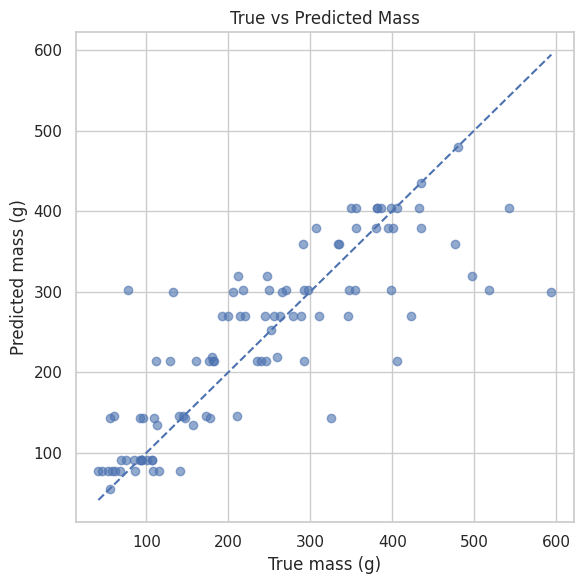

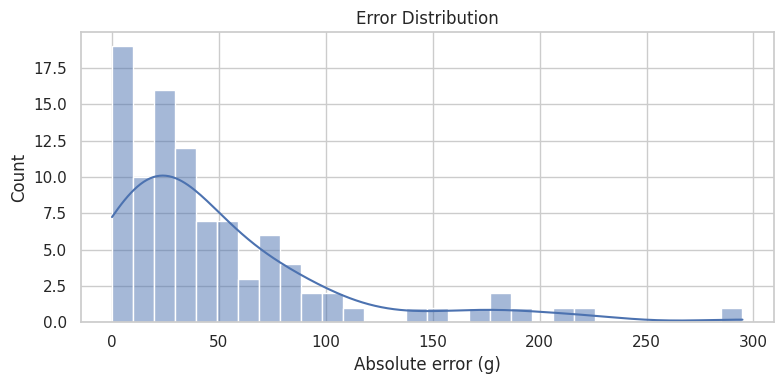

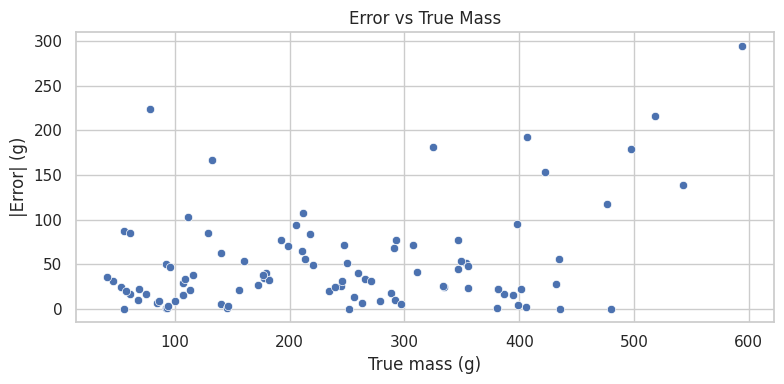

In [13]:
# ===========================================
# CELL 12: Visual error analysis (plots for report)
# ===========================================
plt.figure(figsize=(6, 6))
plt.scatter(results["true_mass_g"], results["pred_mass_g"], alpha=0.6)
min_val = min(results["true_mass_g"].min(), results["pred_mass_g"].min())
max_val = max(results["true_mass_g"].max(), results["pred_mass_g"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("True mass (g)")
plt.ylabel("Predicted mass (g)")
plt.title("True vs Predicted Mass")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(results["abs_error_g"], bins=30, kde=True)
plt.xlabel("Absolute error (g)")
plt.title("Error Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x="true_mass_g", y="abs_error_g", data=results)
plt.xlabel("True mass (g)")
plt.ylabel("|Error| (g)")
plt.title("Error vs True Mass")
plt.tight_layout()
plt.show()


In [14]:
# ===========================================
# CELL 13: Save cache for fast re-run (06_part1)
# ===========================================
cache_data = {
    "feature_cols": feature_cols,
    "best_lgbm_params": best_lgbm_params,
    "individual_maes": individual_maes,
    "meta_results": meta_results,
    "best_meta_name": best_meta_name,
    "best_calib_name": best_calib_name,
    "final_metrics": {
        "mae": float(final_mae),
        "rmse": float(final_rmse),
        "mape": float(final_mape),
        "r2": float(final_r2),
    },
    "train_shape": X_train.shape,
    "test_shape": X_test.shape,
}

save_cache(cache_data, "06_part1")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/06_part1.pkl
